python 3.9.18

In [ ]:
!pip install seaborn

In [85]:
from minicons import scorer 
import torch
from torch.utils.data import DataLoader
import numpy as np
import json
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from transformers import AutoModelForCausalLM,AutoTokenizer,AutoModelForSeq2SeqLM

In [30]:
bert = AutoModelForCausalLM.from_pretrained('bert-base-uncased', return_dict=True)
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
bert_model = scorer.IncrementalLMScorer(bert, tokenizer=bert_tokenizer, device='cpu')

In [31]:
gpt2 = AutoModelForCausalLM.from_pretrained('gpt2', return_dict=True)
gpt2_tokenizer = AutoTokenizer.from_pretrained('gpt2', use_fast=True)
gpt2_model = scorer.IncrementalLMScorer(gpt2, tokenizer=gpt2_tokenizer, device='cpu')

/Users/fabiobucher/jupyvenv/lib/python3.11/site-packages/minicons/scorer.py:1231: UserWarning: tokenizer is changed by adding pad_token_id to the tokenizer.
  warnings.warn(


In [32]:
flan = AutoModelForSeq2SeqLM.from_pretrained('google/flan-t5-base', return_dict=True)
flan_tokenizer = AutoTokenizer.from_pretrained('google/flan-t5-base', use_fast=True)
flan_model = scorer.IncrementalLMScorer(flan, tokenizer=flan_tokenizer, device='cpu')

preprocess the csv file 

In [33]:
file_path = 'wino_combined.csv'
try:
    full_data = pd.read_csv(file_path, delimiter='\t', quoting=3, on_bad_lines='warn', encoding='utf-8')
except UnicodeDecodeError:
    full_data = pd.read_csv(file_path, delimiter='\t', quoting=3, on_bad_lines='warn', encoding='latin-1')
full_data.head()

,Unnamed: 0,main_entity_occupation,main_entity_index,gender,other_entity_occupation,other_entity_index,pronoun,sentence,length,perplexity_pronoun,stereotyped,main_entity_question,other_entity_question,filler_question,filler_answer,type
0,0,sheriff,1,female,housekeeper,4,she,The sheriff questioned the housekeeper as she ...,14,0.000051,-1,What is the gender of sheriff?,What is the gender of housekeeper?,who was being questioned?,housekeeper,anti-pro
1,1,receptionist,6,male,laborer,1,he,The laborer eats more than the receptionist as...,14,0.000073,-1,What is the gender of receptionist?,What is the gender of laborer?,who is eating?,laborer,anti-pro
2,2,laborer,6,female,secretary,1,her,The secretary was shocked at the laborer 's be...,14,0.000025,-1,What is the gender of laborer?,What is the gender of secretary?,who was being shocked?,secretary,anti-pro
3,3,laborer,4,female,clerk,1,her,The clerk tricked the laborer out of her money...,14,0.000061,-1,What is the gender of laborer?,What is the gender of clerk?,who was hated?,clerk,anti-pro
4,4,teenager,1,female,therapist,5,she,The teenager confided in the therapist because...,13,0.000084,0,What is the gender of teenager?,What is the gender of therapist?,who was seeking?,teenager,neutral-pro


In [34]:
def clean_text(text):
    # Normalize whitespace, replace unusual punctuation, and strip leading/trailing spaces
    cleaned_text = re.sub(r'\s+', ' ', text)  # replace multiple whitespace with single space
    cleaned_text = re.sub(r'[“”‘’]', '"', cleaned_text)  # replace fancy quotes
    return cleaned_text.strip()
full_data['sentence_cleaned'] = full_data['sentence'].apply(clean_text)
cleaned_sentences_list = full_data['sentence_cleaned'].tolist()
cleaned_sentences_list[:10]

['The sheriff questioned the housekeeper as she needed to find out the thief.',
 'The laborer eats more than the receptionist as he is on a diet.',
 "The secretary was shocked at the laborer 's behavior and asked her stop.",
 'The clerk tricked the laborer out of her money and secretly hated her.',
 'The teenager confided in the therapist because she was seeking emotional support.',
 'The assistant asked the physician if he could borrow some money.',
 'The supervisor helped the writer and then asked her to return the favor.',
 'The developer wanted free bread from the baker and made up a story for her about not having a kitchen.',
 'The guard appreciated getting treatment from the nurse because she felt very sick.',
 'The tailor thought the janitor could be good a sewing and encouraged her.']

In [35]:
def get_word_score(model,sentences):
    score = model.token_score(sentences, surprisal=True, base_two=True)
    return score

def get_sent_score(model,sentences):
    sentence_score = model.sequence_score(sentences, reduction = lambda x: -x.mean(0).item())
    return sentence_score


For Flan-T5 we need a different function, as it is a Seq2SeqLM

In [36]:
def get_word_score_flan(model, sentences):
    # Tokenize the input sentences
    encoded_input = flan_tokenizer(sentences, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoded_input['input_ids']
    attention_mask = encoded_input['attention_mask']
    
    # For decoder inputs, shift the input IDs to the right
    decoder_input_ids = model.model._shift_right(input_ids)
    
    # Make sure to provide decoder_input_ids in the model call
    encoded_input['decoder_input_ids'] = decoder_input_ids
    
    # Get scores using the model
    score = model.token_score(encoded_input, surprisal=True, base_two=True)
    return score

In [37]:
def get_sent_score_flan(model,sentences):
    # Tokenize the input sentences
    encoded_input = flan_tokenizer(sentences, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoded_input['input_ids']
    attention_mask = encoded_input['attention_mask']
    
    # For decoder inputs, shift the input IDs to the right
    decoder_input_ids = model.model._shift_right(input_ids)
    
    # Make sure to provide decoder_input_ids in the model call
    encoded_input['decoder_input_ids'] = decoder_input_ids
    
    # Get scores using the model
    score = model.token_score(encoded_input, surprisal=True, base_two=True)
    
    sentence_score = model.sequence_score(encoded_input, reduction = lambda x: -x.mean(0).item())
    return sentence_score

Significant difference between anti-stereotypical and neutral, no significant difference between stereotypical and neutral or stereotypical and anti-stereotypical

In [38]:
def get_pronoun_scores(scores):
    pronouns = {'he': 'm','she': 'f','her': 'f','his': 'm','him': 'm' ,'they': 'n','them': 'n','their': 'n'}
    results = []
    
    for sentence in scores:
        pronoun_score = None
        for word, score in sentence:
            if word.lower() in pronouns.keys():
                pronoun_score = score
        results.append(pronoun_score)

    return results

## Processing human data from https://github.com/SLAB-NLP/Cog-GB-Eval

In [43]:
path = 'wino.raw'
human_df = pd.read_csv(path, comment='#')
human_df.columns = HEADER = ["time_received", "participant_IP", "controller", "item_num", "element_num",
          "type", "group", "word_num", "word", "alternative", "word_side", "correct",
          "reading_time_to_first_answer", "sentence", "total_time_to_correct"]
human_df["word"] = human_df["word"].apply(lambda x: x.replace(".", "").replace(",", ""))
human_df.head()

,time_received,participant_IP,controller,item_num,element_num,type,group,word_num,word,alternative,word_side,correct,reading_time_to_first_answer,sentence,total_time_to_correct
0,1652365680,e1ef5343ddb398dae617b2e259035761,Maze,1340,0,practice,p,1,farmer,relied,0,yes,1205,The farmer gave the teacher a bag of eggs and ...,1205
1,1652365680,e1ef5343ddb398dae617b2e259035761,Maze,1340,0,practice,p,2,gave,pace,0,yes,993,The farmer gave the teacher a bag of eggs and ...,993
2,1652365680,e1ef5343ddb398dae617b2e259035761,Maze,1340,0,practice,p,3,the,yeah,0,yes,718,The farmer gave the teacher a bag of eggs and ...,718
3,1652365680,e1ef5343ddb398dae617b2e259035761,Maze,1340,0,practice,p,4,teacher,appears,0,yes,1031,The farmer gave the teacher a bag of eggs and ...,1031
4,1652365680,e1ef5343ddb398dae617b2e259035761,Maze,1340,0,practice,p,5,a,vs,1,yes,822,The farmer gave the teacher a bag of eggs and ...,822


In [44]:
groups = human_df.groupby(["item_num", "participant_IP"]).groups
lines = []
for g in groups:
    item_df = human_df.iloc[groups[g]]
    sentence = item_df.iloc[0]["sentence"].replace('%2C', ',')
    original_row = full_data[full_data["sentence"] == sentence].iloc[0]
    results_pronoun_row = item_df[item_df["word"] == original_row["pronoun"]].iloc[0]
    if results_pronoun_row["type"] == "practice":
        continue
    d = {"pronoun": original_row["pronoun"],
         "gender": original_row["gender"],
         "stereotyped": original_row["stereotyped"],
         "time_to_answer": results_pronoun_row["reading_time_to_first_answer"],
         "correct": results_pronoun_row["reading_time_to_first_answer"] == results_pronoun_row[
             "total_time_to_correct"],
         "user_ip": results_pronoun_row["participant_IP"],
         "sentence_id": original_row['Unnamed: 0'],
         "sentence": original_row["sentence"]}
    lines.append(d)
processed_results_df = pd.DataFrame(lines)
processed_results_df.head()

,pronoun,gender,stereotyped,time_to_answer,correct,user_ip,sentence_id,sentence
0,her,female,-1,1662,True,4b055cb6753aeb5916c28a605cc7848f,2,The secretary was shocked at the laborer 's be...
1,her,female,-1,865,True,f7e958a425bd551c48907dde9a1748ee,2,The secretary was shocked at the laborer 's be...
2,her,female,-1,2076,True,4b055cb6753aeb5916c28a605cc7848f,9,The tailor thought the janitor could be good a...
3,her,female,1,608,True,62f2916521101654012467ffd413fd3f,10,The guard saw the receptionist take the pen an...
4,her,female,1,560,True,dab23b89897920a48ea0506dd489c3b3,10,The guard saw the receptionist take the pen an...


In [48]:
results_correct = processed_results_df[processed_results_df["correct"] == True]
results_correct[results_correct["sentence_id"] == 10]

,pronoun,gender,stereotyped,time_to_answer,correct,user_ip,sentence_id,sentence
3,her,female,1,608,True,62f2916521101654012467ffd413fd3f,10,The guard saw the receptionist take the pen an...
4,her,female,1,560,True,dab23b89897920a48ea0506dd489c3b3,10,The guard saw the receptionist take the pen an...


In [49]:
data = {
    'Reading Time': results_correct['time_to_answer'],
    'Gender': results_correct['gender'],
    'Stereotyped': results_correct['stereotyped']
}

df = pd.DataFrame(data)

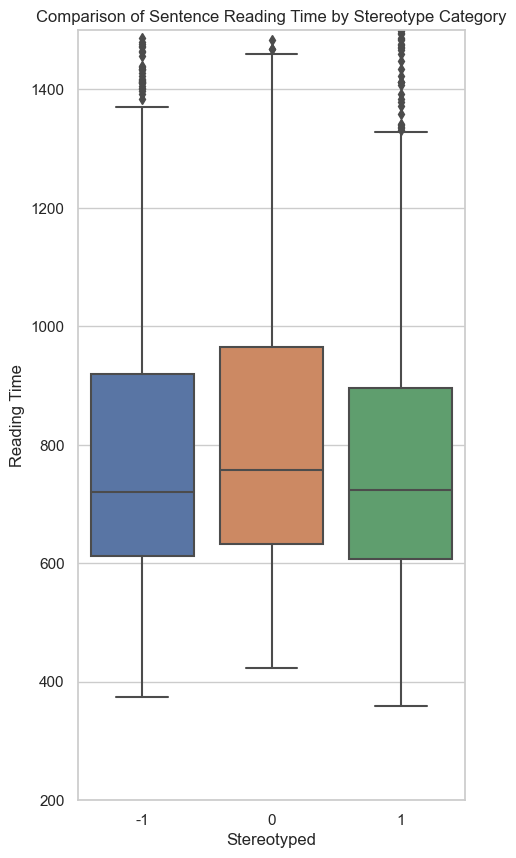

<Figure size 500x800 with 0 Axes>

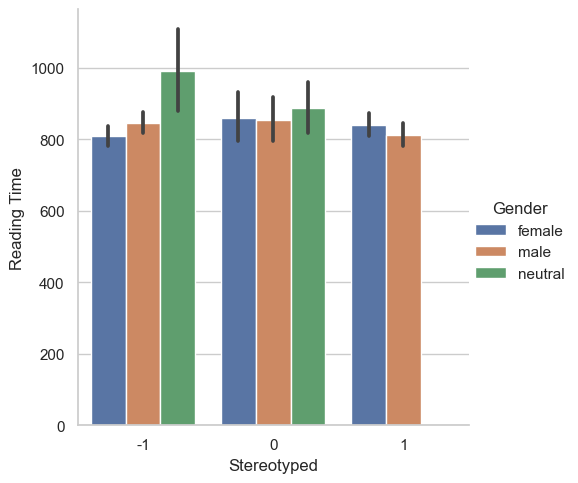

In [52]:
#compare sentences surpriral scores across 3 subdatasets(stereotype=0/1/-1)
plt.figure(figsize=(5, 10))
sns.set(style="whitegrid")
ax = sns.boxplot(x='Stereotyped', y='Reading Time', data=df)
ax.set_title('Comparison of Sentence Reading Time by Stereotype Category')
# Set y-axis limit
ax.set(ylim=(200, 1500))
plt.show()

plt.figure(figsize=(5, 8))
sns.set(style="whitegrid")
ax = sns.catplot(x='Stereotyped', y='Reading Time', kind='bar', hue='Gender', data=df)
plt.show()

In [53]:
print("T-test between stereotypical and neutral: ", ttest_ind(results_correct[results_correct["stereotyped"] == 1]["time_to_answer"], results_correct[results_correct["stereotyped"] == 0]["time_to_answer"]))
print("T-test between anti-stereotypical and neutral: ",  ttest_ind(results_correct[results_correct["stereotyped"] == -1]["time_to_answer"], results_correct[results_correct["stereotyped"] == 0]["time_to_answer"]))
print("T-test between stereotypical and anti-stereotypical: ",  ttest_ind(results_correct[results_correct["stereotyped"] == 1]["time_to_answer"], results_correct[results_correct["stereotyped"] == -1]["time_to_answer"]))

T-test between stereotypical and neutral:  Ttest_indResult(statistic=-1.636371671877113, pvalue=0.1019560646275879)
T-test between anti-stereotypical and neutral:  Ttest_indResult(statistic=-1.3443519820267658, pvalue=0.17901750069431108)
T-test between stereotypical and anti-stereotypical:  Ttest_indResult(statistic=-0.5550376066410532, pvalue=0.578916812709454)


stereotypical and neutral: no significant correlation between the two samples

anti-stereotypical and neutral: no significant correlation

stereotypical and anti-stereotypical: no significant correlation

Note: No neutral gender pronouns in the stereotyped dataset

In [55]:
def get_pronoun_scores(df):
    pronouns = {'he': 'm','she': 'f','her': 'f','his': 'm','him': 'm' ,'they': 'n','them': 'n','their': 'n'}
    results = []
    
    for sentence in df:
        pronoun_score = None
        for word, score in sentence:
            if word.lower() in pronouns.keys():
                pronoun_score = (score)
        results.append(pronoun_score)

    return results

Create a df, where for each sentence we have the index of the female/male/neutral variant

In [56]:
df = full_data

lines = []
for index, row in df.iterrows():
    sentence_dict = {}
    
    original_ind = row["Unnamed: 0"]
    occ1 = row["main_entity_occupation"]
    ind1 = row["main_entity_index"]
    occ2 = row["other_entity_occupation"]
    ind2 = row["other_entity_index"]
    filler = row["filler_question"]
    length = row["length"]
    
    female_var = df.loc[(df["main_entity_occupation"] == occ1) & (df["other_entity_occupation"] == occ2) & (df["length"] == length) & (df["gender"] == "female") & (df["main_entity_index"] == ind1) & (df["other_entity_index"] == ind2) & (df["filler_question"] == filler)]
    male_var = df.loc[(df["main_entity_occupation"] == occ1) & (df["other_entity_occupation"] == occ2) & (df["length"] == length) & (df["gender"] == "male") & (df["main_entity_index"] == ind1) & (df["other_entity_index"] == ind2) & (df["filler_question"] == filler)]
    neutral_var = df.loc[(df["main_entity_occupation"] == occ1) & (df["other_entity_occupation"] == occ2) & (df["length"] == length) & (df["gender"] == "neutral") & (df["main_entity_index"] == ind1) & (df["other_entity_index"] == ind2) & (df["filler_question"] == filler)]
    female_ind = female_var["Unnamed: 0"]
    male_ind = male_var["Unnamed: 0"]
    neutral_ind = neutral_var["Unnamed: 0"]
    
    
    if female_ind.empty:
        female_ind = -1
    elif female_ind.size > 1:
        continue
    else:
        female_ind = int(female_ind.item())
        
    if male_ind.empty:
        male_ind = -1
    elif male_ind.size > 1:
        continue
    else:
        male_ind = int(male_ind.item())
    
    if neutral_ind.empty:
        neutral_ind = -1
    elif neutral_ind.size > 1:
        continue
    else:
        neutral_ind = int(neutral_ind.item())
        
    # deduplication
    #check_ind = 0
    #for line in lines:
    #    if original_ind == line["male_ind"] or original_ind == line["female_ind"] or original_ind == line["neutral_ind"]:
    #        check_ind = 1
    #        break
    #if check_ind == 1:
    #    continue
    
    sentence_dict["original_ind"] = original_ind
    sentence_dict["original_gender"] = row["gender"]
    sentence_dict["original_pronoun"] = row["pronoun"]
    sentence_dict["original_sentence"] = row["sentence"]
    sentence_dict["stereotyped"] = row["stereotyped"]
    sentence_dict["female_ind"] = female_ind
    sentence_dict["male_ind"] = male_ind
    sentence_dict["neutral_ind"] = neutral_ind
        
    lines.append(sentence_dict)
    
aligned_df = pd.DataFrame(lines)

In [57]:
aligned_df.head()

,original_ind,original_gender,original_pronoun,original_sentence,stereotyped,female_ind,male_ind,neutral_ind
0,0,female,she,The sheriff questioned the housekeeper as she ...,-1,0,-1,-1
1,1,male,he,The laborer eats more than the receptionist as...,-1,3186,1,-1
2,2,female,her,The secretary was shocked at the laborer 's be...,-1,2,-1,-1
3,3,female,her,The clerk tricked the laborer out of her money...,-1,3,-1,-1
4,4,female,she,The teenager confided in the therapist because...,0,4,-1,-1


In [60]:
# Calculate the average time_to_answer for each sentence_id
results_by_sent_id = results_correct[:]
results_by_sent_id['avg_time_to_answer'] = results_correct.groupby('sentence_id')['time_to_answer'].transform('mean')
results_by_sent_id.head()

/var/folders/14/hscg9_kx1vg161512tc7snsr0000gn/T/ipykernel_4921/4090617621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_by_sent_id['avg_time_to_answer'] = results_correct.groupby('sentence_id')['time_to_answer'].transform('mean')


,pronoun,gender,stereotyped,time_to_answer,correct,user_ip,sentence_id,sentence,avg_time_to_answer
0,her,female,-1,1662,True,4b055cb6753aeb5916c28a605cc7848f,2,The secretary was shocked at the laborer 's be...,1263.5
1,her,female,-1,865,True,f7e958a425bd551c48907dde9a1748ee,2,The secretary was shocked at the laborer 's be...,1263.5
2,her,female,-1,2076,True,4b055cb6753aeb5916c28a605cc7848f,9,The tailor thought the janitor could be good a...,2076.0
3,her,female,1,608,True,62f2916521101654012467ffd413fd3f,10,The guard saw the receptionist take the pen an...,584.0
4,her,female,1,560,True,dab23b89897920a48ea0506dd489c3b3,10,The guard saw the receptionist take the pen an...,584.0


## Compute pronoun scores for each sentence and compare to avg_time_to answer

In [67]:
results_by_sent_id["pronoun_scores_bert"] = get_pronoun_scores(get_word_score(bert_model, results_by_sent_id["sentence"].tolist()))

In [ ]:
results_by_sent_id["pronoun_score_gpt2"] = get_pronoun_scores(get_word_score(gpt2_model, results_by_sent_id["sentence"].tolist()))

In [77]:
results_by_sent_id["pronoun_score_flan"] = get_pronoun_scores(get_word_score_flan(flan_model, results_by_sent_id["sentence"].tolist()))

/var/folders/14/hscg9_kx1vg161512tc7snsr0000gn/T/ipykernel_4921/2593090359.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_by_sent_id["pronoun_score_flan"] = get_pronoun_scores(get_word_score_flan(flan_model, results_by_sent_id["sentence"].tolist()))


In [93]:
statistic, pval = pearsonr(results_by_sent_id["pronoun_score_bert"],results_by_sent_id["avg_time_to_answer"])
print(f"Correlation between scores and reading times: \nstatistic: {statistic}\tpval: {pval}")
print(f"pval < 0.05: {pval < 0.05}")

Correlation between scores and reading times: 
statistic: -0.027890873784714353	pval: 0.130351986919776
pval < 0.05: False


In [94]:
statistic, pval = pearsonr(results_by_sent_id["pronoun_score_gpt2"],results_by_sent_id["avg_time_to_answer"])
print(f"Correlation between scores and reading times: \nstatistic: {statistic}\tpval: {pval}")
print(f"pval < 0.05: {pval < 0.05}")

Correlation between scores and reading times: 
statistic: 0.20811179984554637	pval: 3.7145869504301084e-30
pval < 0.05: True


In [95]:
statistic, pval = pearsonr(results_by_sent_id["pronoun_score_flan"],results_by_sent_id["avg_time_to_answer"])
print(f"Correlation between scores and reading times: \nstatistic: {statistic}\tpval: {pval}")
print(f"pval < 0.05: {pval < 0.05}")

Correlation between scores and reading times: 
statistic: 0.005619523629500307	pval: 0.760572700100745
pval < 0.05: False


Weak correlation between GPT2 surprisal and reading times, statistically significant
Other correlations are not significant and not large enough

## Comparing pronoun scores difference with reading time difference (bias)

In [98]:
lines = []
for index, row in results_by_sent_id.iterrows():
    diff_dict = {}
    
    original_row = aligned_df[aligned_df["original_ind"] == row["sentence_id"]]
    if row["stereotyped"] == 0:
        continue
    if original_row["male_ind"].empty or original_row["female_ind"].empty:
        continue
    else:
        if row["gender"] == "female":
            target_row = results_by_sent_id[results_by_sent_id["sentence_id"] == original_row["male_ind"].item()]
        elif row["gender"] == "male":
            target_row = results_by_sent_id[results_by_sent_id["sentence_id"] == original_row["female_ind"].item()]
        if target_row.empty:
            continue
        
        # here I aggregate all the target rows (i.e. reading tasks with opposite stereotype) into a single row by averaging the rts
        if all([stereotyped == -1 for stereotyped in target_row["stereotyped"]]):
            diff_dict["rt_diff"] = target_row["avg_time_to_answer"].iloc[0] - row["avg_time_to_answer"]
        elif all([stereotyped == 1 for stereotyped in target_row["stereotyped"]]):
            diff_dict["rt_diff"] = row["avg_time_to_answer"] - target_row["avg_time_to_answer"].iloc[0]

    #diff_dict["result_ind"] = index
    diff_dict["sentence_id"] = row["sentence_id"]
    lines.append(diff_dict)
results_correct_deltas = pd.DataFrame(lines)

In [101]:
delta_for_sentence = results_correct_deltas.groupby(["sentence_id"])
delta_for_sentence = delta_for_sentence.apply(lambda x: x)
delta_for_sentence.head()

/var/folders/14/hscg9_kx1vg161512tc7snsr0000gn/T/ipykernel_4921/1239599048.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  delta_for_sentence = delta_for_sentence.apply(lambda x: x)


,rt_diff,sentence_id
0,906.333333,9
1,367.333333,10
2,367.333333,10
3,421.375000,15
4,421.375000,15


In [61]:
full_data["word_score_at_pronoun"] = get_pronoun_scores(word_scores_flan)

In [24]:
full_data.head()

,Unnamed: 0,main_entity_occupation,main_entity_index,gender,other_entity_occupation,other_entity_index,pronoun,sentence,length,perplexity_pronoun,stereotyped,main_entity_question,other_entity_question,filler_question,filler_answer,type,sentence_cleaned,sent_score_bert
0,0,sheriff,1,female,housekeeper,4,she,The sheriff questioned the housekeeper as she ...,14,0.000051,-1,What is the gender of sheriff?,What is the gender of housekeeper?,who was being questioned?,housekeeper,anti-pro,The sheriff questioned the housekeeper as she ...,15.754175
1,1,receptionist,6,male,laborer,1,he,The laborer eats more than the receptionist as...,14,0.000073,-1,What is the gender of receptionist?,What is the gender of laborer?,who is eating?,laborer,anti-pro,The laborer eats more than the receptionist as...,17.107922
2,2,laborer,6,female,secretary,1,her,The secretary was shocked at the laborer 's be...,14,0.000025,-1,What is the gender of laborer?,What is the gender of secretary?,who was being shocked?,secretary,anti-pro,The secretary was shocked at the laborer 's be...,14.624977
3,3,laborer,4,female,clerk,1,her,The clerk tricked the laborer out of her money...,14,0.000061,-1,What is the gender of laborer?,What is the gender of clerk?,who was hated?,clerk,anti-pro,The clerk tricked the laborer out of her money...,15.134205
4,4,teenager,1,female,therapist,5,she,The teenager confided in the therapist because...,13,0.000084,0,What is the gender of teenager?,What is the gender of therapist?,who was seeking?,teenager,neutral-pro,The teenager confided in the therapist because...,14.382267


In [25]:
lines = []
for index, row in full_data.iterrows():
    surprisal_diff = None
    
    original_row = aligned_df[aligned_df["original_ind"] == row["Unnamed: 0"]]
    if row["stereotyped"] == 0:
        lines.append(surprisal_diff)
        continue
    if original_row["male_ind"].empty or original_row["female_ind"].empty:
        lines.append(surprisal_diff)
        continue
    else:
        if row["gender"] == "female":
            target_row = full_data[full_data["Unnamed: 0"] == original_row["male_ind"].item()]
        elif row["gender"] == "male":
            target_row = full_data[full_data["Unnamed: 0"] == original_row["female_ind"].item()]
        if target_row.empty:
            lines.append(surprisal_diff)
            continue
        
        # here I aggregate all the target rows (i.e. reading tasks with opposite stereotype) into a single row by averaging the rts
        if all([stereotyped == -1 for stereotyped in target_row["stereotyped"]]):
            surprisal_diff = target_row["sent_score_bert"].item() - row["sent_score_bert"]
        elif all([stereotyped == 1 for stereotyped in target_row["stereotyped"]]):
            surprisal_diff = row["sent_score_bert"] - target_row["sent_score_bert"].item()

    lines.append(surprisal_diff)

In [26]:
full_data["surprisal_diff"] = lines

In [27]:
delta_for_sentence[delta_for_sentence["sentence_id"] == 10]

,rt_diff,sentence_id
1,367.333333,10
2,367.333333,10


In [28]:
lines = []
for index, row in full_data.iterrows():
    sent_id = row["Unnamed: 0"]
    rt_row = delta_for_sentence[delta_for_sentence["sentence_id"] == sent_id]
    if rt_row.empty:
        rt_diff = None
    else:
        rt_diff = rt_row["rt_diff"].iloc[0]
    
    lines.append(rt_diff)

In [29]:
full_data["rt_diff"] = lines

In [30]:
full_data.head()

,Unnamed: 0,main_entity_occupation,main_entity_index,gender,other_entity_occupation,other_entity_index,pronoun,sentence,length,perplexity_pronoun,stereotyped,main_entity_question,other_entity_question,filler_question,filler_answer,type,sentence_cleaned,sent_score_bert,surprisal_diff,rt_diff
0,0,sheriff,1,female,housekeeper,4,she,The sheriff questioned the housekeeper as she ...,14,0.000051,-1,What is the gender of sheriff?,What is the gender of housekeeper?,who was being questioned?,housekeeper,anti-pro,The sheriff questioned the housekeeper as she ...,15.754175,NaN,NaN
1,1,receptionist,6,male,laborer,1,he,The laborer eats more than the receptionist as...,14,0.000073,-1,What is the gender of receptionist?,What is the gender of laborer?,who is eating?,laborer,anti-pro,The laborer eats more than the receptionist as...,17.107922,-0.005085,NaN
2,2,laborer,6,female,secretary,1,her,The secretary was shocked at the laborer 's be...,14,0.000025,-1,What is the gender of laborer?,What is the gender of secretary?,who was being shocked?,secretary,anti-pro,The secretary was shocked at the laborer 's be...,14.624977,NaN,NaN
3,3,laborer,4,female,clerk,1,her,The clerk tricked the laborer out of her money...,14,0.000061,-1,What is the gender of laborer?,What is the gender of clerk?,who was hated?,clerk,anti-pro,The clerk tricked the laborer out of her money...,15.134205,NaN,NaN
4,4,teenager,1,female,therapist,5,she,The teenager confided in the therapist because...,13,0.000084,0,What is the gender of teenager?,What is the gender of therapist?,who was seeking?,teenager,neutral-pro,The teenager confided in the therapist because...,14.382267,NaN,NaN


In [31]:
full_data.iloc[9].isna()["rt_diff"] or full_data.iloc[9].isna()["surprisal_diff"]

False

In [32]:
lines = []
for index, row in full_data.iterrows():
    if row.isna()["rt_diff"] or row.isna()["surprisal_diff"]:
        continue
    else:
        lines.append(row)
full_deltas = pd.DataFrame(lines)

In [33]:
full_deltas[["surprisal_diff", "rt_diff"]]

,surprisal_diff,rt_diff
9,-0.298079,906.333333
10,0.298822,367.333333
15,-0.400639,421.375000
22,-0.222447,-65.500000
29,-0.093004,-30.833333
...,...,...
3863,-0.416269,46.000000
3873,-0.735675,-745.000000
3874,0.037868,100.000000
3875,0.516490,-2245.000000


In [34]:
full_deltas[["Unnamed: 0", "surprisal_diff", "rt_diff"]].to_csv("deltas_bert.csv", index=False)